# langgraph-codeact

This library [`langgraph-codeact`](https://github.com/langchain-ai/langgraph-codeact) implements the [CodeAct architecture](https://arxiv.org/abs/2402.01030) in LangGraph. This is the architecture is used by [Manus.im](https://manus.im/). It implements an alternative to JSON function-calling, which enables solving more complex tasks in less steps. This is achieved by making use of the full power of a Turing complete programming language (such as Python used here) to combine and transform the outputs of multiple tools.

## Features

- Message history is saved between turns, to support follow-up questions
- Python variables are saved between turns, which enables more advanced follow-up questions
- Use .invoke() to get just the final result, or .stream() to get token-by-token output, see example below
- You can use any custom tools you wrote, any LangChain tools, or any MCP tools
- You can use this with any model supported by LangChain (but we've only tested with Claude 3.7 so far)
- You can bring your own code sandbox, with a simple functional API
- The system message is customizable

## Installation

```bash
pip install langgraph-codeact
```

To run the example install also

```bash
pip install langchain langchain-openai
```

## Example 1: Math

### 1. Define your tools

You can use any tools you want, including custom tools, LangChain tools, or MCP tools. In this example, we define a few simple math functions.

In [2]:
import math

from langchain_core.tools import tool

def add(a: float, b: float) -> float:
    """Add two numbers together."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers together."""
    return a * b

def divide(a: float, b: float) -> float:
    """Divide two numbers."""
    return a / b

def subtract(a: float, b: float) -> float:
    """Subtract two numbers."""
    return a - b

def sin(a: float) -> float:
    """Take the sine of a number."""
    return math.sin(a)

def cos(a: float) -> float:
    """Take the cosine of a number."""
    return math.cos(a)

def radians(a: float) -> float:
    """Convert degrees to radians."""
    return math.radians(a)

def exponentiation(a: float, b: float) -> float:
    """Raise one number to the power of another."""
    return a**b

def sqrt(a: float) -> float:
    """Take the square root of a number."""
    return math.sqrt(a)

def ceil(a: float) -> float:
    """Round a number up to the nearest integer."""
    return math.ceil(a)

tools = [
    add,
    multiply,
    divide,
    subtract,
    sin,
    cos,
    radians,
    exponentiation,
    sqrt,
    ceil,
]

### 2. Bring-your-own code sandbox

You can use any code sandbox you want, pass it in as a function which accepts two arguments

- the string of code to run
- the dictionary of locals to run it in (includes the tools, and any variables you set in the previous turns)

> Use a sandboxed environment in production! The `eval` function below is just for demonstration purposes, not safe!

In [10]:
import builtins
import contextlib
import io
from typing import Any


def eval(code: str, _locals: dict[str, Any]) -> tuple[str, dict[str, Any]]:
    # Store original keys before execution
    original_keys = set(_locals.keys())

    try:
        with contextlib.redirect_stdout(io.StringIO()) as f:
            exec(code, builtins.__dict__, _locals)
        result = f.getvalue()
        if not result:
            result = "<code ran, no output printed to stdout>"
    except Exception as e:
        result = f"Error during execution: {repr(e)}"

    # Determine new variables created during execution
    new_keys = set(_locals.keys()) - original_keys
    new_vars = {key: _locals[key] for key in new_keys}
    return result, new_vars

### 3. Create the CodeAct graph

You can also customize the prompt, through the prompt= argument.

In [11]:
from langchain.chat_models import init_chat_model
from langgraph_codeact import create_codeact
from langgraph.checkpoint.memory import MemorySaver

model = init_chat_model("openai:claude-3.7-sonnet")

code_act = create_codeact(model, tools, eval)
agent = code_act.compile(checkpointer=MemorySaver())

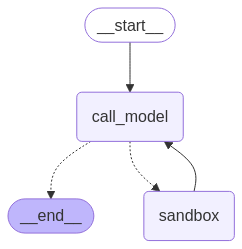

In [7]:
from IPython.display import Image

Image(agent.get_graph().draw_mermaid_png())

### 4. Run it!

You can use the `.invoke()` method to get the final result, or the `.stream()` method to get token-by-token output.

In [12]:
messages = [{
    "role": "user",
    "content": "A batter hits a baseball at 45.847 m/s at an angle of 23.474° above the horizontal. The outfielder, who starts facing the batter, picks up the baseball as it lands, then throws it back towards the batter at 24.12 m/s at an angle of 39.12 degrees. How far is the baseball from where the batter originally hit it? Assume zero air resistance."
}]
for typ, chunk in agent.stream(
    {"messages": messages},
    stream_mode=["values", "messages"],
    config={"configurable": {"thread_id": 1}},
):
    if typ == "messages":
        print(chunk[0].content, end="")
    elif typ == "values":
        print("\n\n---answer---\n\n", chunk)



---answer---

 {'messages': [HumanMessage(content='A batter hits a baseball at 45.847 m/s at an angle of 23.474° above the horizontal. The outfielder, who starts facing the batter, picks up the baseball as it lands, then throws it back towards the batter at 24.12 m/s at an angle of 39.12 degrees. How far is the baseball from where the batter originally hit it? Assume zero air resistance.', additional_kwargs={}, response_metadata={}, id='801adba8-519a-4cf4-a2dd-288028a22ac9')]}
I'll solve this step by step by calculating where the baseball lands after being hit by the batter, and then where it lands after being thrown by the outfielder.

First, let's calculate where the baseball lands after being hit by the batter:

```python
# Constants
g = 9.8  # acceleration due to gravity in m/s^2

# Batter's hit parameters
v0_batter = 45.847  # initial velocity in m/s
angle_batter_deg = 23.474  # angle in degrees
angle_batter = radians(angle_batter_deg)  # convert to radians

# Calculate componen

👆 LangSmith Trace: https://smith.langchain.com/public/eeb100e4-a48e-4a4d-9bf4-469c837e265e/r

## Example 2: Cipher

In [14]:
import base64
import builtins
import contextlib
import io
from typing import Any

from langchain.chat_models import init_chat_model
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver

from langgraph_codeact import create_codeact, create_default_prompt


def eval(code: str, _locals: dict[str, Any]) -> tuple[str, dict[str, Any]]:
    # Store original keys before execution
    original_keys = set(_locals.keys())

    try:
        with contextlib.redirect_stdout(io.StringIO()) as f:
            exec(code, builtins.__dict__, _locals)
        result = f.getvalue()
        if not result:
            result = "<code ran, no output printed to stdout>"
    except Exception as e:
        result = f"Error during execution: {repr(e)}"

    # Determine new variables created during execution
    new_keys = set(_locals.keys()) - original_keys
    new_vars = {key: _locals[key] for key in new_keys}
    return result, new_vars


def caesar_shift_decode(text: str, shift: int) -> str:
    """Decode text that was encoded using Caesar shift.

    Args:
        text: The encoded text to decode
        shift: The number of positions to shift back (positive number)

    Returns:
        The decoded text
    """
    result = ""
    for char in text:
        if char.isalpha():
            # Determine the case and base ASCII value
            ascii_base = ord("A") if char.isupper() else ord("a")
            # Shift the character back and wrap around if needed
            shifted = (ord(char) - ascii_base - shift) % 26
            result += chr(ascii_base + shifted)
        else:
            result += char
    return result


def base64_decode(text: str) -> str:
    """Decode text that was encoded using base64.

    Args:
        text: The base64 encoded text to decode

    Returns:
        The decoded text as a string

    Raises:
        Exception: If the input is not valid base64
    """
    # Add padding if needed
    padding = 4 - (len(text) % 4)
    if padding != 4:
        text += "=" * padding

    # Decode the base64 string
    decoded_bytes = base64.b64decode(text)
    return decoded_bytes.decode("utf-8")


def caesar_shift_encode(text: str, shift: int) -> str:
    """Encode text using Caesar shift.

    Args:
        text: The text to encode
        shift: The number of positions to shift forward (positive number)

    Returns:
        The encoded text
    """
    result = ""
    for char in text:
        if char.isalpha():
            # Determine the case and base ASCII value
            ascii_base = ord("A") if char.isupper() else ord("a")
            # Shift the character forward and wrap around if needed
            shifted = (ord(char) - ascii_base + shift) % 26
            result += chr(ascii_base + shifted)
        else:
            result += char
    return result


def base64_encode(text: str) -> str:
    """Encode text using base64.

    Args:
        text: The text to encode

    Returns:
        The base64 encoded text as a string
    """
    # Convert text to bytes and encode
    text_bytes = text.encode("utf-8")
    encoded_bytes = base64.b64encode(text_bytes)
    return encoded_bytes.decode("utf-8")


# List of available tools
tools = [
    caesar_shift_decode,
    base64_decode,
    caesar_shift_encode,
    base64_encode,
]

model = init_chat_model("openai:claude-3.7-sonnet")
code_act = create_codeact(
    model,
    tools,
    eval,
    prompt=create_default_prompt(
        tools,
        "Once you have the final answer, respond to the user with plain text, do not respond with a code snippet.",
    ),
)
agent = code_act.compile(checkpointer=MemorySaver())


In [15]:
def stream_from_agent(messages: list[dict], config: RunnableConfig):
    for typ, chunk in agent.stream(
        {"messages": messages},
        stream_mode=["values", "messages"],
        config=config,
    ):
        if typ == "messages":
            print(chunk[0].content, end="")
        elif typ == "values":
            print("\n\n---answer---\n\n", chunk)

In [16]:
# first turn
config = {"configurable": {"thread_id": 1}}
stream_from_agent(
    [
        {
            "role": "user",
            "content": "Decipher this text: 'VGhybCB6dnRsYW9wdW4gZHZ1a2x5bWJz'",
        }
    ],
    config,
)



---answer---

 {'messages': [HumanMessage(content="Decipher this text: 'VGhybCB6dnRsYW9wdW4gZHZ1a2x5bWJz'", additional_kwargs={}, response_metadata={}, id='ec863777-e88f-4333-8358-5aa70e9aa4ff')]}
I'll decipher this text. It looks like it might be encoded in multiple layers. Let me start by trying to decode it from base64.

```python
decoded_text = base64_decode('VGhybCB6dnRsYW9wdW4gZHZ1a2x5bWJz')
print("After base64 decoding:", decoded_text)
```

Now that I have the base64-decoded text, I'll try to see if it's further encoded with a Caesar shift. I'll try different shift values to see if any produce readable text.

```python
# Try different Caesar shift values
for shift in range(1, 26):
    possible_plaintext = caesar_shift_decode(decoded_text, shift)
    print(f"Shift {shift}: {possible_plaintext}")
```

Looking at the results, I can identify that the text was first encoded with base64, and then the decoded result was encrypted with a Caesar shift cipher.

The original message is: 

👆 LangSmith Trace: https://smith.langchain.com/public/bd68f469-d2ff-4e5d-b1ab-bcee5c5cd411/r

In [17]:
# second turn
stream_from_agent(
    [
        {
            "role": "user",
            "content": "Using the same cipher as the original text, encode this text: 'The work is mysterious and important'",
        }
    ],
    config,
)



---answer---

 {'messages': [HumanMessage(content="Decipher this text: 'VGhybCB6dnRsYW9wdW4gZHZ1a2x5bWJz'", additional_kwargs={}, response_metadata={}, id='ec863777-e88f-4333-8358-5aa70e9aa4ff'), AIMessage(content='I\'ll decipher this text. It looks like it might be encoded in multiple layers. Let me start by trying to decode it from base64.\n\n```python\ndecoded_text = base64_decode(\'VGhybCB6dnRsYW9wdW4gZHZ1a2x5bWJz\')\nprint("After base64 decoding:", decoded_text)\n```\n\nNow that I have the base64-decoded text, I\'ll try to see if it\'s further encoded with a Caesar shift. I\'ll try different shift values to see if any produce readable text.\n\n```python\n# Try different Caesar shift values\nfor shift in range(1, 26):\n    possible_plaintext = caesar_shift_decode(decoded_text, shift)\n    print(f"Shift {shift}: {possible_plaintext}")\n```\n\nLooking at the results, I can identify that the text was first encoded with base64, and then the decoded result was encrypted with a Caesar 

👆 LangSmith Trace: https://smith.langchain.com/public/8e9e2a83-e5f1-4006-ba7c-68d961fea02d/r